In [1]:
# REQUIREMENT for spacy
# !python -m spacy download de_core_news_sm

In [9]:
import re
import os
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor


german_spell_check = SpellChecker(language='de')
spacy_nlp = spacy.load('de_core_news_sm') 

## Data Overview

In [3]:
df_protocols = pd.read_csv('./data/all_bundestagsprotokolle.csv')
df_protocols.head()

,speaker,party,speech,date,applause_grüne,applause_linke,applause_fdp,applause_cdu/csu,applause_spd,applause_afd,shout_grüne,shout_linke,shout_fdp,shout_cdu/csu,shout_spd,shout_afd
0,Gabriele Katzmarek,SPD,Sie ist nicht in Stein gemeißelt – das wissen ...,2021-10-26,1,0,1,1,1,0,0,0,0,0,0,0
1,Stefan Müller,CDU/CSU,"Ich sage das deswegen, weil Demokratie ja imme...",2021-10-26,4,3,4,4,4,2,0,0,0,0,0,0
2,Britta Haßelmann,BÜNDNIS 90/DIE GRÜNEN,"Liebe Kolleginnen und Kollegen, meine Damen un...",2021-10-26,8,4,5,5,6,0,0,0,0,0,0,0
3,Marco Buschmann,FDP,"Entscheidend ist aber, dass wir heute das auss...",2021-10-26,2,2,3,2,2,1,0,0,0,0,0,0
4,Stephan Brandner,AfD,"Meine Damen und Herren, lassen Sie uns kurz ü...",2021-10-26,0,1,0,0,1,9,0,0,0,0,1,0


In [4]:
df_articles_self = pd.read_csv('./data/all_articles_self.csv')
df_articles_self.head()

,title,url,summary,last_edit_date,authors,text,topic,source,tags
0,EU und China planen Verhandlungen über möglich...,https://www.zeit.de/wirtschaft/2024-06/e-autos...,Die EU hatte China mit Strafzöllen auf E-Autos...,2024-06-22 20:20:54+02:00,['Stella Männer'],China und die EU wollen im Streit über Strafzö...,E-Autos,"Quelle: ZEIT ONLINE,\n Reuters,\n ...","['China', 'EU-Kommission', 'Aktuelle Themen']"
1,Da will ich doch wohl mal hoffen,https://www.zeit.de/2024/27/ostdeutschland-lan...,"Warum es wichtig ist, auch das Gute zu sehen. ...",2024-06-22 18:14:07+02:00,[],Neulich besuchte ich Freunde in Dresden. Wir s...,Ostdeutschland,Aus der\n ZEIT Nr. 27/2024,"['Ostdeutschland', 'Alternative für Deutschlan..."
2,Medaillenvergabe an Javier Milei im Hamburg bl...,https://www.zeit.de/politik/2024-06/argentinie...,Wenige hundert Menschen haben gegen eine Ehrun...,2024-06-22 22:30:00+02:00,['Sarah Vojta'],Hunderte Menschen haben in Hamburg gegen die V...,Argentiniens Präsident,"Quelle: ZEIT ONLINE,\n dpa","['Argentinien', 'Hamburg', 'Aktuelle Themen']"
3,Belgien siegt gegen Rumänien,https://www.zeit.de/sport/2024-06/belgien-ruma...,Belgien gewinnt nach Treffern von Tielemans un...,2024-06-22 23:00:26+02:00,[],Am zweiten Spieltag der Gruppe E hat Belgien m...,"Fußball EM, Gruppe E",NaN,"['Belgien', 'Rumänien', 'Fußball', 'Aktuelle T..."
4,Portugal steht im Achtelfinale,https://www.zeit.de/sport/2024-06/tuerkei-port...,Mit einem Sieg gegen die Türkei ist Portugal G...,2024-06-22 20:48:00+02:00,['Sarah Vojta'],Am zweiten Spieltag der Gruppe F hat Portugal ...,"Fußball-EM, Gruppe F","Quelle: ZEIT ONLINE,\n dpa","['Portugal', 'Türkei', 'Cristiano Ronaldo', 'D..."


In [5]:
df_articles_news = pd.read_csv('./data/all_articles_newspaper4k.csv')
df_articles_news.head()

,title,url,summary,last_edit_date,authors,text
0,E-Autos: EU und China planen Verhandlungen übe...,https://www.zeit.de/wirtschaft/2024-06/e-autos...,Die EU hatte China mit Strafzöllen auf E-Autos...,2024-06-22 20:20:54+02:00,"['Stella Männer', 'www.zeit.de']",China und die EU wollen im Streit über Strafzö...
1,Ostdeutschland: Da will ich doch wohl mal hoffen,https://www.zeit.de/2024/27/ostdeutschland-lan...,"Die Karten, auf denen Ostdeutschland fast komp...",2024-06-22 18:14:07+02:00,"['Valerie Schönian', 'www.zeit.de']",Neulich besuchte ich Freunde in Dresden. Wir s...
2,Argentiniens Präsident: Medaillenvergabe an Ja...,https://www.zeit.de/politik/2024-06/argentinie...,Wenige hundert Menschen haben gegen eine Ehrun...,2024-06-22 22:30:00+02:00,"['Sarah Vojta', 'www.zeit.de']",Hunderte Menschen haben in Hamburg gegen die V...
3,"Fußball EM, Gruppe E : Belgien siegt gegen Rum...",https://www.zeit.de/sport/2024-06/belgien-ruma...,Belgien gewinnt nach Treffern von Tielemans un...,2024-06-22 23:00:26+02:00,"['Melina Crispin', 'www.zeit.de']",Belgien – Rumänien 2:0 (1:0)\n\nAm zweiten Spi...
4,"Fußball-EM, Gruppe F: Portugal steht im Achtel...",https://www.zeit.de/sport/2024-06/tuerkei-port...,Mit einem Sieg gegen die Türkei ist Portugal G...,2024-06-22 20:48:00+02:00,"['Sarah Vojta', 'www.zeit.de']",Türkei – Portugal 0:3 (0:2)\n\nAm zweiten Spie...


In [6]:
df_protocols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22214 entries, 0 to 22213
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   speaker           22214 non-null  object
 1   party             22213 non-null  object
 2   speech            20107 non-null  object
 3   date              22214 non-null  object
 4   applause_grüne    22214 non-null  int64 
 5   applause_linke    22214 non-null  int64 
 6   applause_fdp      22214 non-null  int64 
 7   applause_cdu/csu  22214 non-null  int64 
 8   applause_spd      22214 non-null  int64 
 9   applause_afd      22214 non-null  int64 
 10  shout_grüne       22214 non-null  int64 
 11  shout_linke       22214 non-null  int64 
 12  shout_fdp         22214 non-null  int64 
 13  shout_cdu/csu     22214 non-null  int64 
 14  shout_spd         22214 non-null  int64 
 15  shout_afd         22214 non-null  int64 
dtypes: int64(12), object(4)
memory usage: 2.7+ MB


In [7]:
df_articles_self.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           179 non-null    object
 1   url             193 non-null    object
 2   summary         190 non-null    object
 3   last_edit_date  193 non-null    object
 4   authors         193 non-null    object
 5   text            191 non-null    object
 6   topic           179 non-null    object
 7   source          112 non-null    object
 8   tags            193 non-null    object
dtypes: object(9)
memory usage: 13.7+ KB


In [8]:
df_articles_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           196 non-null    object
 1   url             196 non-null    object
 2   summary         196 non-null    object
 3   last_edit_date  196 non-null    object
 4   authors         196 non-null    object
 5   text            196 non-null    object
dtypes: object(6)
memory usage: 9.3+ KB


In [9]:
df_protocols.describe()

,applause_grüne,applause_linke,applause_fdp,applause_cdu/csu,applause_spd,applause_afd,shout_grüne,shout_linke,shout_fdp,shout_cdu/csu,shout_spd,shout_afd
count,22214.000000,22214.000000,22214.000000,22214.000000,22214.000000,22214.000000,22214.000000,22214.000000,22214.000000,22214.000000,22214.000000,22214.000000
mean,2.738903,0.588503,2.248042,1.786216,2.792248,0.959845,0.088503,0.016386,0.040650,0.101423,0.102773,0.074683
std,3.209514,1.641145,2.949486,2.739190,3.223207,1.933181,0.436794,0.177270,0.251076,0.505251,0.509327,0.436954
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,0.000000,3.000000,3.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,136.000000,22.000000,133.000000,52.000000,136.000000,23.000000,12.000000,10.000000,6.000000,13.000000,13.000000,12.000000


## Data Cleaning

In [10]:
# merge newspaper columns into self columns where values are missing
# lowercase texts
# remove non alphabetic chars and special characters in text and html encodings e.g. &#34; for 34
# perform stop word removal
# perform lemmatization on text
# self build scraper generally scrapes articles in the standard layout better, but there are also special articles which follow another layout -> we merge these articles (newspaper4k & self merge)

In [11]:
def remove_non_alphabetic_chars(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w ]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower() # we lose information, because in german every noun is capitalized -> nevertheless can be helpful, especially with a small dataset

def correct_word(word):
    corrected = german_spell_check.correction(word)
    return corrected if corrected else word

def perform_spell_check(text):
    doc = spacy_nlp(text)
    return ' '.join([correct_word(token.text) for token in doc if not token.is_stop]) # Tokenization, Stop_Word_Removal and Spellcheck

def clean_text(text, spell_check = True):
    text = remove_non_alphabetic_chars(text)
    # after performing the spell check it can correct non stop_words to stop_words (eaine -> eine) and we need to check for stop_words again
    doc = spacy_nlp(perform_spell_check(text) if spell_check else text) 
    cleaned_text = ' '.join([token.lemma_.lower() for token in doc if not token.is_stop]) # Lemmatization: Reduce words to their base form (not root)
    return cleaned_text

def filter_list(sentences: list[str], words_to_remove: list[str]) -> list[str]:
    filtered_list = []
    for sentence in sentences:
        include_string = True
        for word in words_to_remove:
            if word in sentence:
                include_string = False
                break
        if include_string:
            filtered_list.append(sentence)

    return filtered_list

In [10]:
# clean articles
articles_cleaned_file = "./data/all_articles_cleaned.csv"
if not os.path.exists(articles_cleaned_file):
    df_articles_self.set_index('url', inplace=True)
    df_articles_news.set_index('url', inplace=True)
    
    df_articles_cleaned = df_articles_self.copy()
    df_articles_cleaned = df_articles_cleaned.dropna(subset=['text']) # missing texts -> premium article or media article
    # Fill NaN values in df_articles_cleaned with corresponding values from df_articles_news
    df_articles_cleaned['title'] = df_articles_cleaned['title'].fillna(df_articles_news['title'])
    df_articles_cleaned = df_articles_cleaned.dropna(subset=['title']) 
    df_articles_cleaned['last_edit_date'] = df_articles_cleaned['last_edit_date'].fillna(df_articles_news['last_edit_date'])
    df_articles_cleaned['summary'] = df_articles_cleaned['summary'].fillna(df_articles_news['summary'])
    df_articles_cleaned['tags'] = df_articles_cleaned['tags'].fillna("unbekannt")
    df_articles_cleaned['source'] = df_articles_cleaned['source'].fillna("unbekannt")
    df_articles_cleaned['topic'] = df_articles_cleaned['topic'].fillna("unbekannt")

    author_filter = ["zeit", "index"]
    df_articles_cleaned['authors'] = df_articles_cleaned['authors'].apply(eval)
    df_articles_cleaned['authors'] = df_articles_cleaned['authors'].apply(lambda x: filter_list(x, author_filter))

    df_articles_cleaned[['text', 'summary', 'title', 'topic']] = df_articles_cleaned[['text', 'summary', 'title', 'topic']].map(lambda x: clean_text(x, False))
    df_articles_cleaned.reset_index().to_csv(articles_cleaned_file, index=False)
else:
    df_articles_cleaned = pd.read_csv(articles_cleaned_file)

In [11]:
# clean protocols
protocols_cleaned_file = "./data/all_protocols_cleaned.csv"
if not os.path.exists(protocols_cleaned_file):
    df_protocols_cleaned = df_protocols.copy()
    df_protocols_cleaned = df_protocols_cleaned.dropna(subset=['speech', 'party'])
    df_protocols_cleaned['speech'] = df_protocols_cleaned['speech'].apply(lambda x: clean_text(x, False))
    df_protocols_cleaned = df_protocols_cleaned.dropna(subset=['speech', 'party']) # clean can create new null values
    df_protocols_cleaned = df_protocols_cleaned.drop_duplicates(subset=['speech'])
    df_protocols_cleaned['party'] = df_protocols_cleaned['party'].replace('BÜNDNIS\xa090/DIE GRÜNEN', 'DIE GRÜNEN')

    # I dont need every single minister position and special categories like chancelor for predicting parties
    # Nevertheless it's interesting to include them for analysis, I will group them as Minister
    parties_to_keep = ['DIE GRÜNEN', 'FDP', 'AfD', 'SPD', 'CDU/CSU', 'DIE LINKE']
    df_protocols_cleaned['party'] = df_protocols_cleaned['party'].apply(lambda x: x if x in parties_to_keep else 'Minister')
    
    # Feature Engineering and global vars
    df_protocols_cleaned['total_applause'] = df_protocols_cleaned[[col for col in df_protocols_cleaned.columns if col.startswith('applause_')]].sum(axis=1)
    df_protocols_cleaned['speech_word_count'] = df_protocols_cleaned['speech'].str.split().apply(len)
    
    df_protocols_cleaned = df_protocols_cleaned[df_protocols_cleaned['speech_word_count'] >= 20]
    
    df_protocols_cleaned.to_csv(protocols_cleaned_file, index=False)
else:
    df_protocols_cleaned = pd.read_csv(protocols_cleaned_file)

## Data Analysis

### Parlament Analysis

In [14]:
# global styling
party_palette = {
    'SPD': '#E3000F',       # Red
    'CDU/CSU': '#4a4a4a',   # Black
    'DIE GRÜNEN': '#64A12D',# Green
    'FDP': '#FFED00',       # Yellow
    'AfD': '#009EE0',       # Blue
    'DIE LINKE': '#BE3075',  # Magenta
    'Minister': '#747a76',   # Grey
    'spd': '#E3000F',       # Red
    'cdu/csu': '#4a4a4a',   # Black
    'grüne': '#64A12D',# Green
    'fdp': '#FFED00',       # Yellow
    'afd': '#009EE0',       # Blue
    'linke': '#BE3075',  # Magenta
    'minister': '#747a76'   # Grey
}

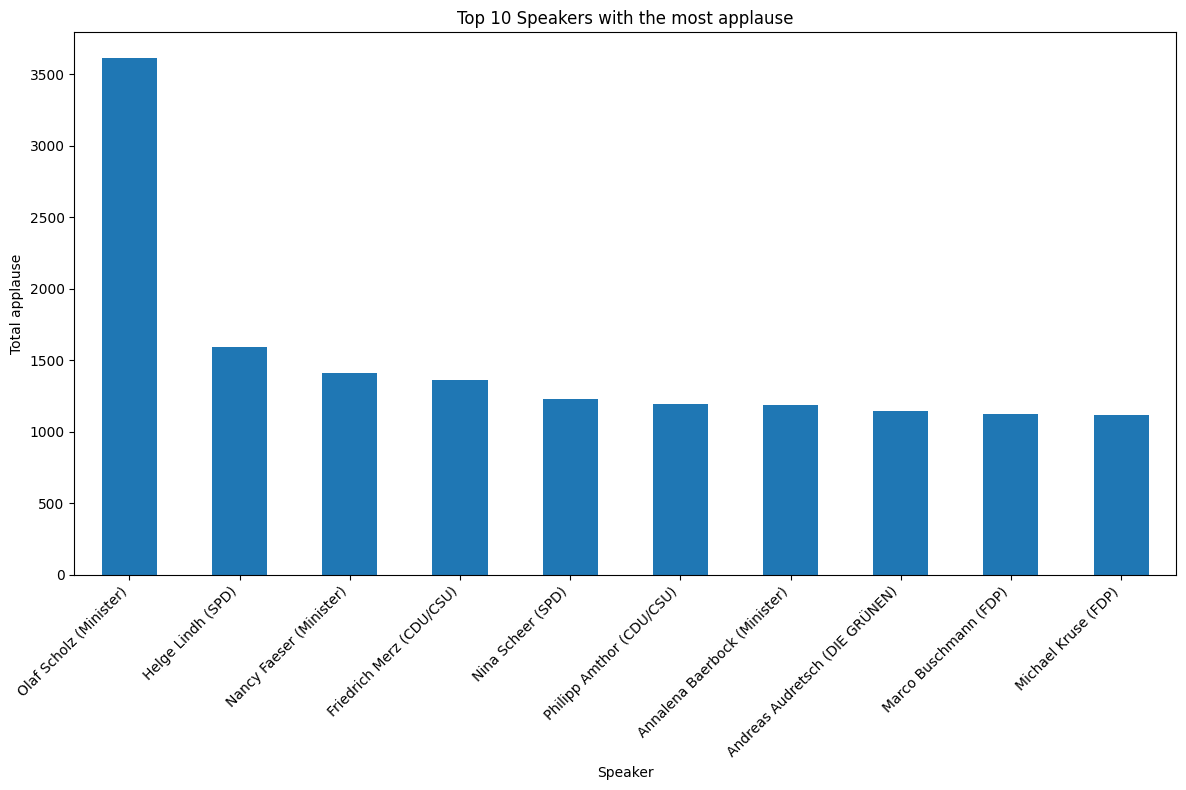

In [15]:
top_10_speakers = df_protocols_cleaned.groupby('speaker')['total_applause'].sum().sort_values(ascending=False).head(10)
top_speakers_info = df_protocols_cleaned[df_protocols_cleaned['speaker'].isin(top_10_speakers.index)].drop_duplicates(subset=['speaker'])[['speaker', 'party']]
speaker_party_mapping = top_speakers_info.set_index('speaker')['party'].to_dict()
labels = [f"{speaker} ({speaker_party_mapping[speaker]})" for speaker in top_10_speakers.index]
# Plotting
plt.figure(figsize=(12, 8))
top_10_speakers.plot(kind='bar')
plt.title('Top 10 Speakers with the most applause')
plt.xlabel('Speaker')
plt.ylabel('Total applause')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

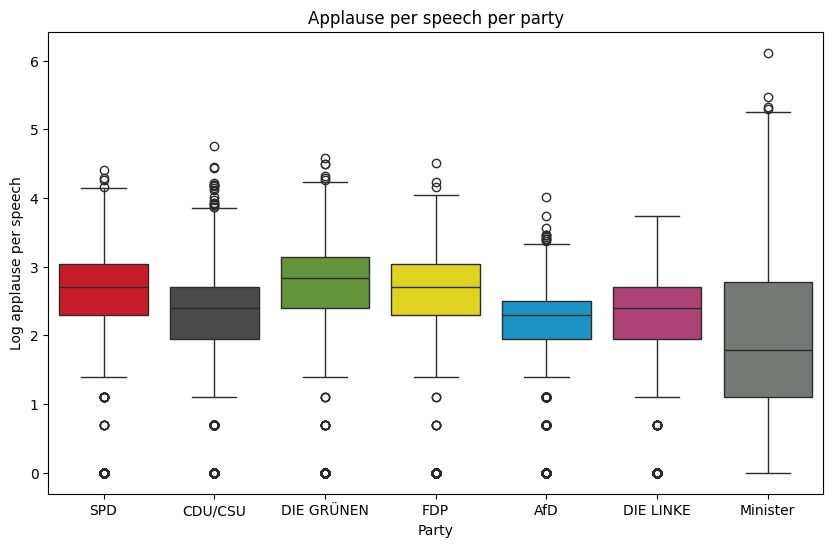

In [16]:
df_protocols_cleaned['log_total_applause'] = np.log1p(df_protocols_cleaned['total_applause'])

# Create a boxplot with the log-transformed data
plt.figure(figsize=(10, 6))
sns.boxplot(x='party', y='log_total_applause', data=df_protocols_cleaned, palette=party_palette, hue='party')
plt.title('Applause per speech per party')
plt.xlabel('Party')
plt.ylabel('Log applause per speech')
plt.show()

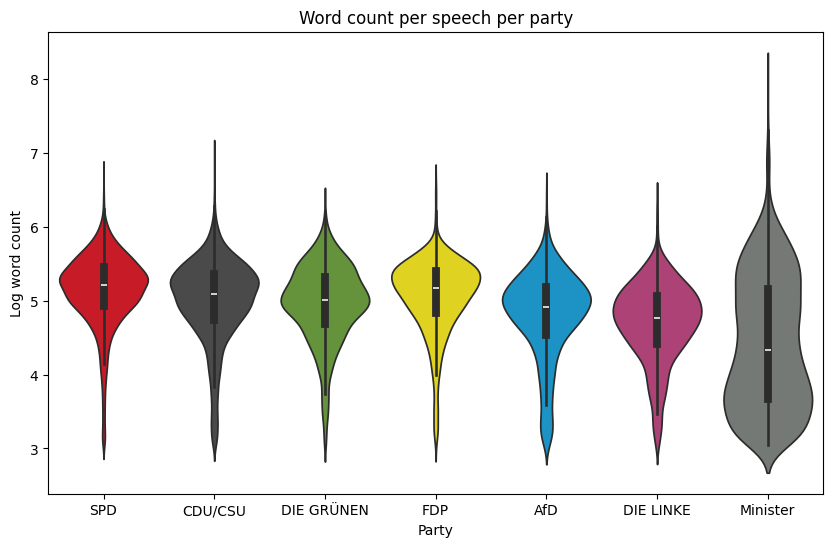

In [17]:
# Boxplot for speech word count per party
df_protocols_cleaned['log_speech_word_count'] = np.log1p(df_protocols_cleaned['speech_word_count'])

plt.figure(figsize=(10, 6))
sns.violinplot(x='party', y='log_speech_word_count', data=df_protocols_cleaned, palette=party_palette, hue='party')
plt.title('Word count per speech per party')
plt.xlabel('Party')
plt.ylabel('Log word count')
plt.show()

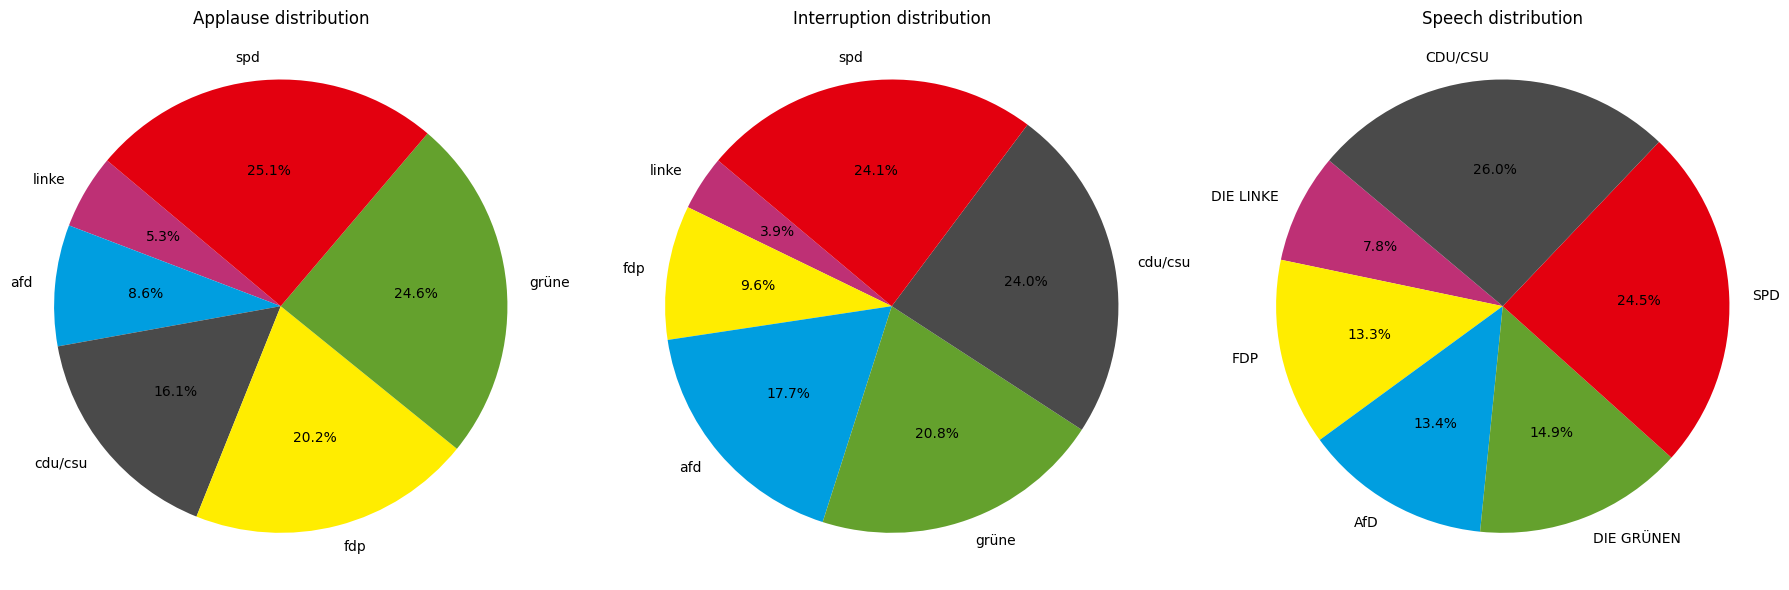

In [18]:
# Applause and interruptions among parties
# The speech distribution nearly equals seats in parlament, little bit different, because ministers are extra category and FDP, GRÜNE and SPD provide ministers
party_applause = df_protocols_cleaned[[col for col in df_protocols_cleaned.columns if col.startswith('applause_')]].sum().sort_values()
party_shouts = df_protocols_cleaned[[col for col in df_protocols_cleaned.columns if col.startswith('shout_')]].sum().sort_values()
party_speeches = df_protocols_cleaned[df_protocols_cleaned['party'] != "Minister"]['party'].value_counts().sort_values()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot pie chart for applause distribution
ax1.pie(party_applause, labels=[party.split('_')[1] for party in party_applause.index], autopct='%1.1f%%', startangle=140, colors=[party_palette[party.split('_')[1]] for party in party_applause.index])
ax1.set_title('Applause distribution')
ax1.axis('equal')

# Shout/Interruption distribution
ax2.pie(party_shouts, labels=[party.split('_')[1] for party in party_shouts.index], autopct='%1.1f%%', startangle=140, colors=[party_palette[party.split('_')[1]] for party in party_shouts.index])
ax2.set_title('Interruption distribution')
ax2.axis('equal')

# Speech distribution
ax3.pie(party_speeches, labels=party_speeches.index, autopct='%1.1f%%', startangle=140, colors=[party_palette[party] for party in party_speeches.index])
ax3.set_title('Speech distribution')
ax3.axis('equal') 

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

### Article Analysis

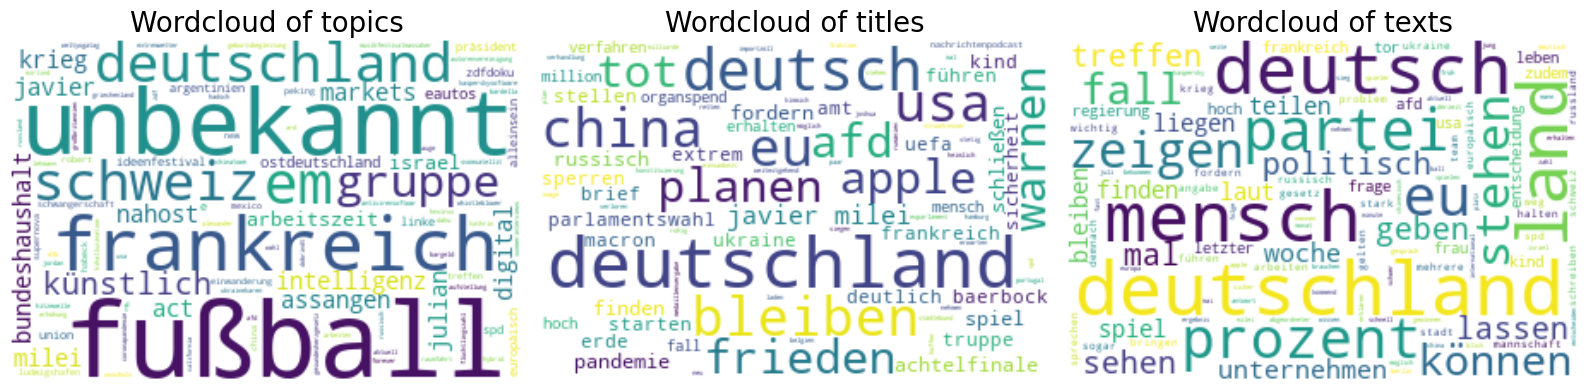

In [19]:
# Wordclouds
all_text = ' '.join(df_articles_cleaned['text'])
all_topics = ' '.join(df_articles_cleaned['topic'])
all_titles = ' '.join(df_articles_cleaned['title'])

def plot_wordcloud(ax, text, title):
    wordcloud = WordCloud(width=300, height=200, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=20)
    ax.axis('off')

fig, axs = plt.subplots(1, 3, figsize=(16, 8))
plot_wordcloud(axs[0], all_topics, 'Wordcloud of topics')
plot_wordcloud(axs[1], all_titles, 'Wordcloud of titles')
plot_wordcloud(axs[2], all_text, 'Wordcloud of texts')
plt.tight_layout()
plt.show()

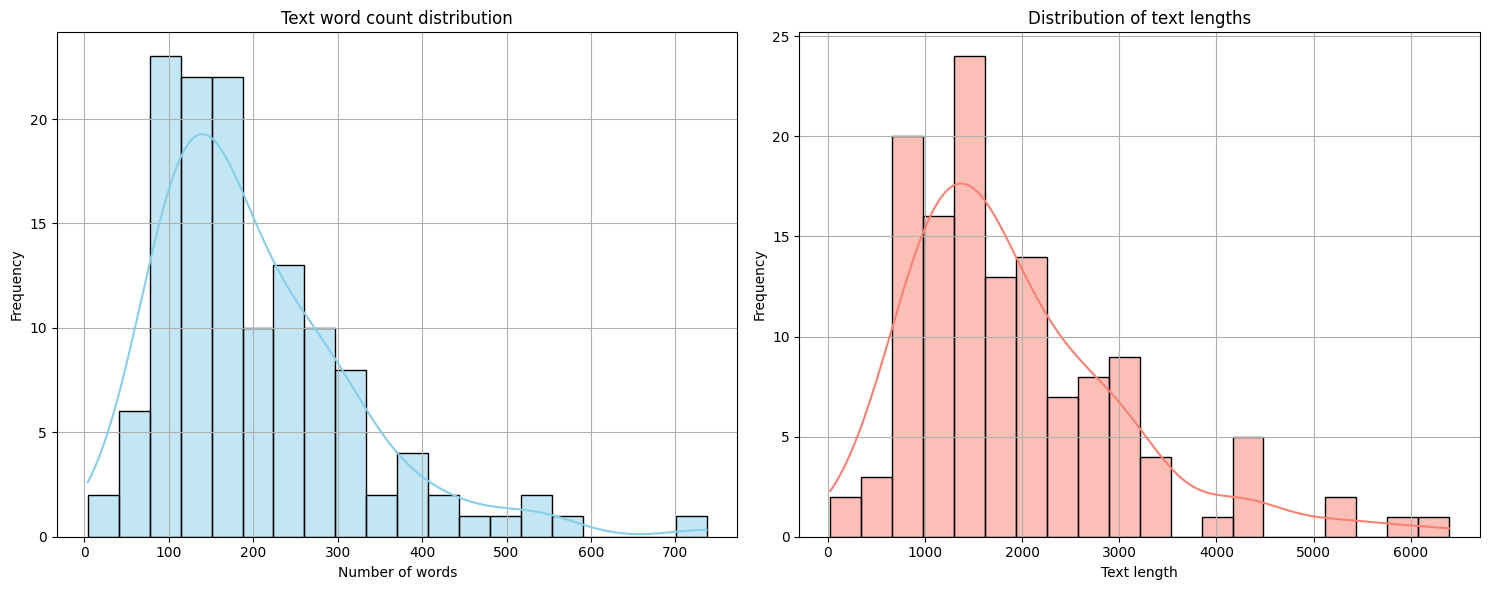

In [21]:
# Plot word count and text length distribution
df_articles_cleaned['text_word_count'] = df_articles_cleaned['text'].apply(lambda x: len(str(x).split()))
df_articles_cleaned['text_length'] = df_articles_cleaned['text'].str.len()

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df_articles_cleaned['text_word_count'], bins=20, kde=True, color='skyblue', ax=axs[0])
axs[0].set_title('Text word count distribution')
axs[0].set_xlabel('Number of words')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

# Plot 2: Text Length Distribution
sns.histplot(df_articles_cleaned['text_length'], bins=20, kde=True, color='salmon', ax=axs[1])
axs[1].set_title('Distribution of text lengths')
axs[1].set_xlabel('Text length')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Models

### Predict Claps
- Claps are like a sentiments but without getting it from words and context

In [44]:
X = df_protocols_cleaned['speech']
y = df_protocols_cleaned['total_applause']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=1000)),
    ('regressor', LinearRegression())
])

param_grid = [
    {
        'regressor': [LinearRegression()]
    },
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [50, 100],
        'regressor__max_depth': [10, 20]
    },
    {
        'regressor': [GradientBoostingRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.1, 0.15]
    },
    {
        'regressor': [MLPRegressor(max_iter=1000)],
        'regressor__hidden_layer_sizes': [(100,50), (50, 50), (100,50,25,5)],
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=7, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

In [42]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Explained variance:", evs)
print("Best Parameters:", grid_search.best_params_)

Mean Squared Error: 44.06312000000001
R2 Score: 0.5311810613113446
Mean Absolute Error: 5.061999999999999
Best Parameters: {'regressor': RandomForestRegressor(), 'regressor__max_depth': 20, 'regressor__n_estimators': 50}


In [76]:
predicted_applause = best_model.predict(df_articles_cleaned['text'])
max_applause = np.percentile(df_protocols_cleaned['total_applause'], 95)
predicted_percentage = (predicted_applause / max_applause) * 100

In [ ]:
# do some visualizations and pick some examples

### Party Classification
- get party of newspaper articles